### Setup

First we need to install all needed dependencies:

In [69]:
%%capture
! pip install einops==0.4.1
! pip install torch==1.11.0
! pip install numpy==1.22.3
! pip install pillow==9.1.0
! pip install requests=2.27.1
! pip install matplotlib==3.5.1

In [70]:
import numpy as np
import requests
import torch
from einops import rearrange, reduce, repeat
from PIL import Image
import matplotlib.pyplot as plt

## Rearrange
With [rearrange](https://cgarciae.github.io/einops/api/rearrange/) we can not simple transpose a matrix or a vector but reorder the axes. Also we can decompose axes for more fancy functionality. 

In [71]:
# Just some matrices for later useage.

X = np.random.rand(2, 3, 4)
Y = np.random.rand(10, 16, 16, 3)

We can simply rearrange axis. Assuming the second and the third axes are width and height we could switch them like this:

In [72]:
A = X.transpose(0, 2, 1)
B = rearrange(X, "a b c -> a c b")

print("X.shape: ", X.shape)
print("A.shape: ", A.shape)
print("B.shape: ", B.shape)

X.shape:  (2, 3, 4)
A.shape:  (2, 4, 3)
B.shape:  (2, 4, 3)


This is also possible using `torch.permute()`:



In [73]:
Xt = torch.from_numpy(X)
C = Xt.permute(0, 2, 1)
print(C.shape)

torch.Size([2, 4, 3])


Rearrange can do more. With it we can also create compositions of axes. Assuming that `np.random.rand(10, 16, 16, 3)` this is a batch of ten colored images of size 16 * 16:

In [74]:
D = rearrange(Y, "b h w c -> (b h) w c")
print(D.shape)

(160, 16, 3)


Let us assume this is a batch (`b`) of images with 3 channels (`c`) and a width (`w`) and a height (`h`) of 16. With `rearrange` we could multiply axes. Here we multiply `h` and `w` by putting them in `( )`. In other words we are flattening the images.

In [75]:
E = rearrange(Y, "b h w c -> b (h w) c")
print(E.shape)

(10, 256, 3)


Let's see how this looks some with real images. Einstein offers himself as a photo model. First we get a few images of Albert. And check the `shape` of the collection:

In [76]:
urls = [
    f"https://raw.githubusercontent.com/chrislemke/einops-playground/main/einsteins/einstein{i}.jpg"
    for i in range(1, 5)
]

images = np.array(
    [np.array(Image.open(requests.get(url, stream=True).raw)) for url in urls]
).astype(float)
print(images.shape)

(4, 96, 96)


Looks like our collection contains 4 images. Interesting foto. 🤔

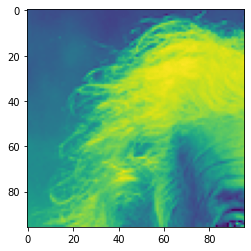

(96, 96)


In [77]:
plt.imshow(images[0])
plt.show()
print(images[0].shape)

What would happen if we play a bit with `rearrange`? Here we do a composition of axes `b` and `h`. The 3D tensor `(4, 96, 96)` is collapsed to a 2D tensor `(384, 96)`. 

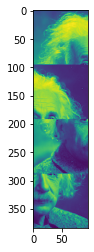

(384, 96)


In [78]:
F = rearrange(images, "b h w -> (b h) w")
plt.imshow(F)
plt.show()
print(F.shape)

Interessting - it seems to be a puzzle of our favourite physicist. Let's try another matrix composition. This time we compose the `b` and `w` axis.

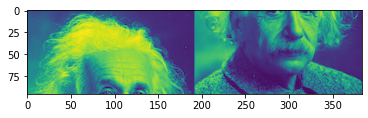

(96, 384)


In [79]:
G = rearrange(images, "b h w -> h (b w)")
plt.imshow(G)
plt.show()
print(G.shape)

Almost - one more try an we solved the puzzle. This time we try something different.

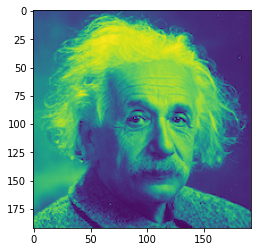

(192, 192)


In [80]:
H = rearrange(images, "(b1 b2) h w -> (b1 h) (b2 w)", b1=2)
plt.imshow(H)
plt.show()
print(H.shape)

Eureka! And for solving it we just had to use `rearrange` and a decomposition of an axis. Here we can see what this [decomposition](https://en.wikipedia.org/wiki/Matrix_decomposition) means to the axes. It is the opposite of the matrix composition. We decompose the `b` axis and with `b1=2` we decompose `4` into `2`. 

We could also decompose it differently. Even if this does not make any sense for image data. Here we decompose the `b` axis but don't 'combine' them with the `h` and `w` axis.

In [81]:
I = rearrange(images, "(b1 b2) h w -> b1 h b2 w", b1=2)
print(I.shape)

(2, 96, 2, 96)


`np.concatenate` can sometimes be pretty useful. Let us check how this works with einops:


In [82]:
print("Y.shape: ", Y.shape)
I = np.concatenate(Y, axis=0)
print("I.shape: ", I.shape)

Y.shape:  (10, 16, 16, 3)
I.shape:  (160, 16, 3)


Here we concatenate the first and the second axis. How about doing this in einops:

In [83]:
J = rearrange(Y, "b h w c -> (b h) w c")
print(J.shape)

(160, 16, 3)


With einops `rearrange` you can also remove or add axes. In NumPy there is `numpy.squeeze`, `numpy.expand_dims`, etc.

In [84]:
K = rearrange(Y, "b h w c -> b 1 h w c")
print("K.shape: ", K.shape)

L = np.expand_dims(Y, 1)
print("L.shape: ", L.shape)

K.shape:  (10, 1, 16, 16, 3)
L.shape:  (10, 1, 16, 16, 3)


When we want to add an axis we simply add an `1` to the position where the axis should be append.

In [85]:
L = rearrange(K, "b 1 h w c -> b h w c")
print("K.shape: ", L.shape)

J = np.squeeze(K, 1)
print("L.shape: ", J.shape)

K.shape:  (10, 16, 16, 3)
L.shape:  (10, 16, 16, 3)


If you want to remove an axis with 1 dimension you simply need to tell `rearrange` which axis you want to remove by using `1` as an identifier in the pattern.

As we can see `rearrange` has a lot of power and makes the whole matrix and vector manipulation pretty simple. No more need for `np.transpose`, `np.expand_dims`, `np.squeeze` etc. But this is only a very small part of the einops library. Next up `einops.reduce`. 

## Reduce

[Reduce](https://cgarciae.github.io/einops/api/reduce/) is another useful function from einops. Besides the tensor and the pattern reduce also expect the reduction method.

Wow! What happened here? I guess it could be helpful to try it with numbers:

In [86]:
X = np.array(
    [
        [[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]],
        [[2, 4, 6, 8], [2, 4, 6, 8], [2, 4, 6, 8], [2, 4, 6, 8]],
    ]
).astype(
    float
)  # Shape: (2, 4, 4)

A = reduce(X, "b h w -> h w", "mean")
print("A.shape: ", A.shape)
print(A)

B = reduce(X, "b h w -> h w", "min")
print("B.shape: ", B.shape)
print(B)

A.shape:  (4, 4)
[[1.5 3.  4.5 6. ]
 [1.5 3.  4.5 6. ]
 [1.5 3.  4.5 6. ]
 [1.5 3.  4.5 6. ]]
B.shape:  (4, 4)
[[1. 2. 3. 4.]
 [1. 2. 3. 4.]
 [1. 2. 3. 4.]
 [1. 2. 3. 4.]]


Now it is easier to see what actually happened. This einops function reduces the axis which is not present in the output by using the method choosen as the second parameter.



In [87]:
A = reduce(X, "b h w ->", "sum")
B = np.sum(X)

print(A)
print(B)

120.0
120.0


## Repeat
With `einops.repeat` we can - surprise - repeat elements. Check this out:

In [88]:
X = np.arange(200).reshape(2, 10, 10)

# print("X: ", X)
print("X.shape: ", X.shape)

A = repeat(X, "b h w -> b new_axis h w", new_axis=3)

# print("\nA: ", A)
print("A.shape: ", A.shape)

X.shape:  (2, 10, 10)
A.shape:  (2, 3, 10, 10)


With `repeat` we can also stretch. Back to Albert:

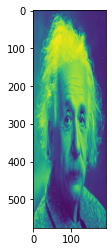

(576, 192)


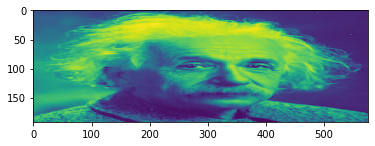

(192, 576)


In [89]:
# Decomposed Albert
B = rearrange(images, "(b1 b2) h w -> (b1 h) (b2 w)", b1=2)

C = repeat(B, "h w -> (h repeat) w", repeat=3)
plt.imshow(C)
plt.show()
print(C.shape)

C = repeat(B, "h w -> h (w 3)")
plt.imshow(C)
plt.show()
print(C.shape)

We can either use a keyword (e.g. `repeat`) and then add the value as a seperate parameter. Or we just use the value directly.

This is just a very small  part of what `repeat` can do. It covers everything `np.repeat` can do - and even more.

## Reduce

Where there is `repeat`, there must be `reduce`. These two truly belong together. 

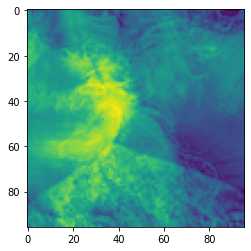

(96, 96)


In [90]:
A = reduce(images, "b h w -> h w", "mean")
plt.imshow(A)
plt.show()
print(A.shape)

Wow! What happened here? I guess it could be helpful to try it with numbers:

In [91]:
X = np.array([[
               [1, 2, 3, 4],
               [1, 2, 3, 4],
               [1, 2, 3, 4],
               [1, 2, 3, 4]
               ]
              ,[
                [2, 4, 6, 8],
                [2, 4, 6, 8],
                [2, 4, 6, 8],
                [2, 4, 6, 8]
                ]]).astype(float) # Shape: (2, 4, 4)

A = reduce(X, 'b h w -> h w', 'mean')
print('A.shape: ', A.shape)
print(A)

B = reduce(X, 'b h w -> h w', 'min')
print('B.shape: ', B.shape)
print(B)

A.shape:  (4, 4)
[[1.5 3.  4.5 6. ]
 [1.5 3.  4.5 6. ]
 [1.5 3.  4.5 6. ]
 [1.5 3.  4.5 6. ]]
B.shape:  (4, 4)
[[1. 2. 3. 4.]
 [1. 2. 3. 4.]
 [1. 2. 3. 4.]
 [1. 2. 3. 4.]]


This notebook is far from being complete. It's more a playground to try all the cool things the einops library offers.